In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

**1:** Create your own gradient descent algorithm, and then test it to find the minimizers of all 8 functions that are detailed in written HW 3 starting from a randomly selected initial value somewhere in the domain (actually use NumPy’s random number generator for the initial guess). Include plots that show convergence, and record how many steps it takes.

In [2]:
def test_function(x): return x**2

In [3]:
def plot_error(fs, method_name, step, max_iter=int(1e5)):
  plt.plot(np.arange(len(fs)), fs)
  if step >= max_iter:
    plt.title(f"{method_name} still didin't converge after {step} steps")
  else:
    plt.title(f"{method_name} converged in {step} steps")
  plt.xlabel('steps')
  plt.ylabel('f(x)')
  plt.show()

The minimizer 0.0004989539738744497 evaluates to 2.489550752216019e-07


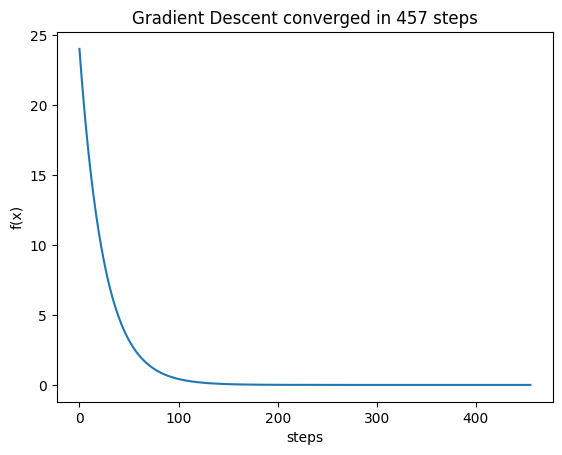

In [4]:
def gradient_descent(f, x0, lr=1e-2, tol=1e-5, max_iter=int(1e5)):
  x = x0.clone().detach().requires_grad_(True)
  xs = []
  fs = []

  for step in range(1, max_iter + 1):  # Gradient descent loop
    y = f(x)
    y.backward()  # Find the gradient
    with torch.no_grad():
      diff = lr * x.grad
      x -= diff
      if torch.norm(diff) < tol: break   # Stop if step is small enough
    x.grad.zero_()  # Zero out gradient

    xs.append(x.detach().numpy().copy())
    fs.append(f(x.detach()).item())  # Use PyTorch to evaluate f

  return xs, fs, step

max_iter = int(1e5)
xs, fs, step = gradient_descent(test_function, torch.tensor(5.), max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

**2:** Do the same as the previous problem, but now for Polyak’s Heavy Ball Method.

The minimizer 0.000493879895657301 evaluates to 2.439173556467722e-07


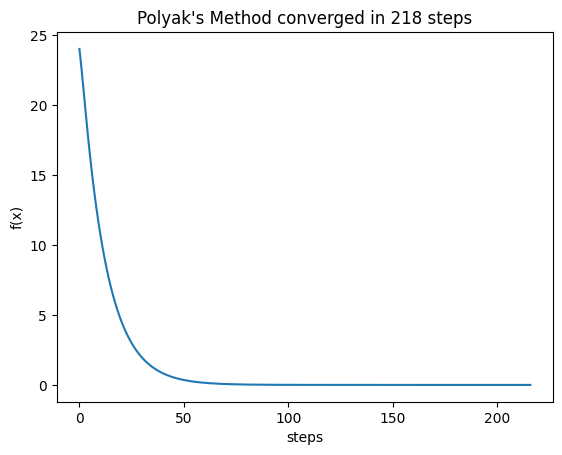

In [40]:
def polyak(f, x0, lr=1e-2, rho=0.1, tol=1e-5, max_iter=int(1e5)):
    x = x0.clone().detach().requires_grad_(True)
    xs = [x.clone().detach().numpy().copy()]  # Initialize with the starting point
    fs = []
    prev_x = x.clone().detach()  # Initialize previous x

    for step in range(1, max_iter + 1):  # Gradient descent loop with Polyak's Heavy Ball method
        y = f(x)
        y.backward()  # Find the gradient
        with torch.no_grad():
            # Compute the Polyak's Heavy Ball update
            u = (1 + rho) * x - rho * prev_x  # Update direction with momentum
            diff = lr * x.grad
            prev_x = x.clone().detach()  # Store the current x for the next step
            x = (u - diff).clone().detach().requires_grad_(True)  # Update x with gradient tracking

            if torch.norm(diff) < tol:  # Stop if the update is small enough
                break

        xs.append(x.detach().numpy().copy())
        fs.append(f(x.detach()).item())  # Use PyTorch to evaluate f

    return xs, fs, step

max_iter = int(1e5)
xs, fs, step = polyak(test_function, torch.tensor(5.), rho=0.5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

**3:** Do the same as the previous problem but now for Nesterov accelerated gradient descent.
Do you have to adjust the parameters for each function, and if so how?

The minimizer 0.00024279256467707455 evaluates to 5.894823118524073e-08


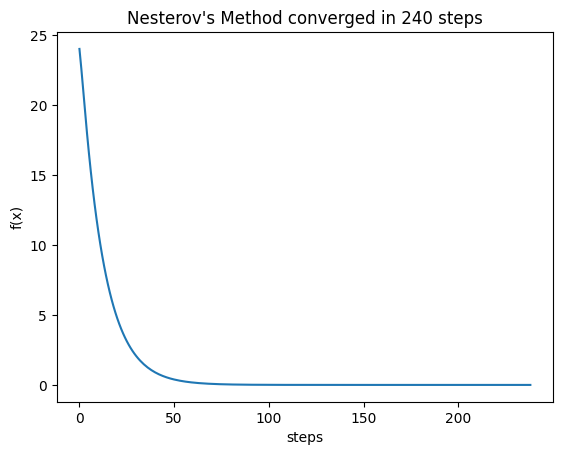

In [52]:
def nesterov(f, x0, lr=1e-2, rho=0.1, tol=1e-5, max_iter=int(1e5)):
    x = x0.clone().detach().requires_grad_(True)
    xs = [x.clone().detach().numpy().copy()]  # Initialize with the starting point
    fs = []
    u = torch.zeros_like(x)  # Initialize the momentum term

    for step in range(1, max_iter + 1):  # Gradient descent loop with Nesterov momentum
        # Compute the look-ahead position
        look_ahead_x = (x + rho * u).detach().requires_grad_(True)

        # Evaluate the function and compute the gradient at the look-ahead position
        y = f(look_ahead_x)
        y.backward()  # Find the gradient at the look-ahead position
        with torch.no_grad():
            u = rho * u - lr * look_ahead_x.grad    # Update the momentum term
            x += u

            if torch.norm(u) < tol:  # Stop if the update is small enough
                break

        look_ahead_x.grad.zero_()  # Zero out gradient
        xs.append(x.detach().numpy().copy())
        fs.append(f(x.detach()).item())  # Use PyTorch to evaluate f

    return xs, fs, step

max_iter = int(1e5)
xs, fs, step = nesterov(test_function, torch.tensor(5.), rho=0.5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

**4:** Repeat this for AdaGrad.

The minimizer 0.6190485954284668 evaluates to 0.3832211494445801


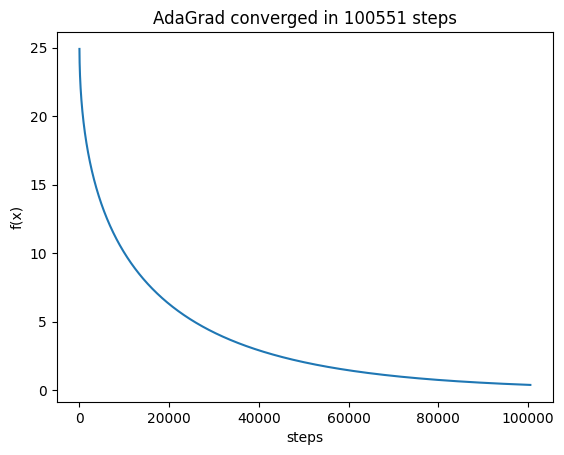

In [65]:
def adagrad(f, x0, lr=1e-2, tol=1e-5, max_iter=int(1e5), epsilon=1e-8):
    x = x0.clone().detach().requires_grad_(True)
    xs = []
    fs = []
    accumulated_grad_sq = torch.zeros_like(x)  # Initialize the accumulated squared gradient to zero

    for step in range(1, max_iter + 1):  # Gradient descent loop
        y = f(x)
        y.backward()  # Find the gradient
        with torch.no_grad():
            accumulated_grad_sq += x.grad ** 2  # Accumulate the squared gradient
            adjusted_lr = lr / (torch.sqrt(accumulated_grad_sq) + epsilon)  # Compute AdaGrad-adjusted learning rate
            diff = adjusted_lr * x.grad
            x -= diff
            if torch.norm(diff) < tol:
                break  # Stop if step is small enough
        x.grad.zero_()  # Zero out gradient

        xs.append(x.detach().numpy().copy())
        fs.append(f(x.detach()).item())  # Use PyTorch to evaluate f

    return xs, fs, step

max_iter = int(5e5)
xs, fs, step = adagrad(test_function, torch.tensor(5.), max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

**5:** Repeat for Adam.

The minimizer 6.257436790946258e-09 evaluates to 3.9155514120038724e-17


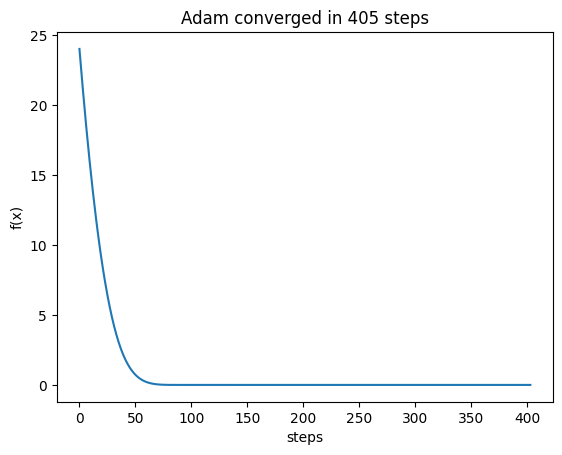

In [110]:
def adam(f, x0, lr=1e-2, tol=1e-5, max_iter=int(1e5), epsilon=1e-8, beta1=0.9, beta2=0.999):
    x = x0.clone().detach().requires_grad_(True)  # Initialize x
    xs = []  # List to store x values
    fs = []  # List to store function values

    m = torch.zeros_like(x)  # First moment vector
    v = torch.zeros_like(x)  # Second moment vector

    for step in range(1, max_iter + 1):  # Optimization loop
        y = f(x)  # Evaluate the function
        y.backward()  # Compute the gradient

        with torch.no_grad():
            m = beta1 * m + (1 - beta1) * x.grad  # Update first moment
            v = beta2 * v + (1 - beta2) * (x.grad ** 2)  # Update second moment

            m_hat = m / (1 - beta1 ** step)  # Bias-corrected first moment
            v_hat = v / (1 - beta2 ** step)  # Bias-corrected second moment

            diff = lr * m_hat / (torch.sqrt(v_hat) + epsilon)  # Update step
            x -= diff  # Apply update

            # Check if the update step size is small enough to stop
            if torch.norm(diff) < tol:
                break

        x.grad.zero_()  # Zero out gradient

        xs.append(x.detach().numpy().copy())  # Store x values
        fs.append(f(x.detach()).item())  # Store function values

    return xs, fs, step

max_iter = int(5e5)
xs, fs, step = adam(test_function, torch.tensor(5.), max_iter=max_iter, lr=1e-1, tol=1e-10)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

**Equation 1**
\begin{align*}
    f(x_1,x_2) &= (1.5-x_1+x_1x_2)^2+(2.25-x_1+x_1x_2^2)^2+(2.625-x_1+x_1x_2^3)^2 \\
    &-4.5\leq x_k\leq 4.5
\end{align*}
($(3,\frac{1}{2})$ is the minimizer which evaluates to $0$)

In [14]:
def f(x):
  x1, x2 = x
  sum = (1.5-x1+x1*x2)**2 + (2.25-x1+x1*x2**2)**2 + (2.625-x1+x1*x2**3)**2
  return sum

The minimizer [-0.16983004 -0.16687079] evaluates to 16.531979659087643


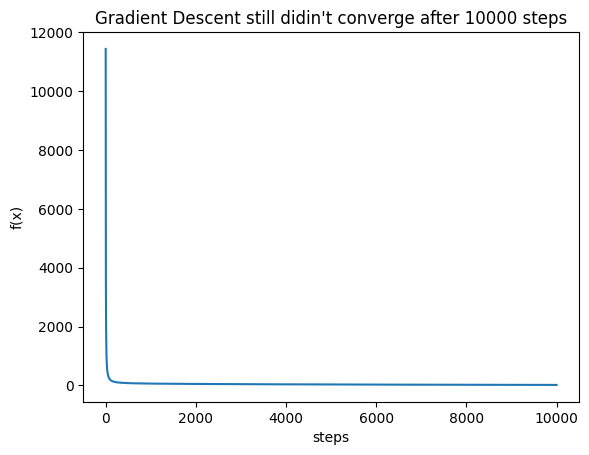

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-4.5, 4.5, 2)

max_iter = 10000
xs, fs, step = gradient_descent(f, torch.tensor(x0), lr=1e-5, tol=1e-8, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

This didn't work that well. At least the convergence got very slow at the end that the optimal value wasn't reached.

The minimizer [-3.11078365  1.25408108] evaluates to 0.8826733158956352


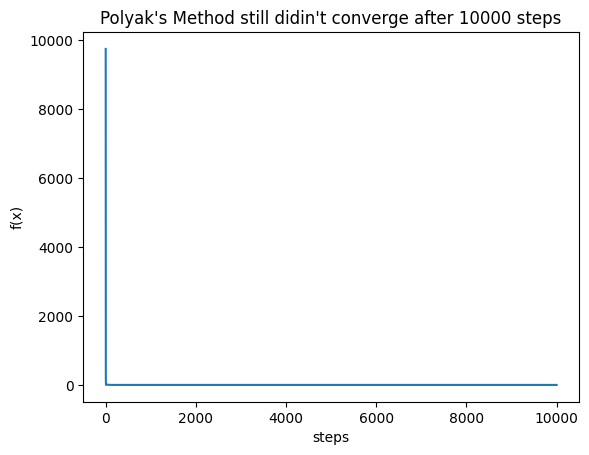

In [18]:
# Polyak's Method
x0 = np.random.uniform(-4.5, 4.5, 2)

max_iter = 10000
xs, fs, step = polyak(f, torch.tensor(x0), lr=1e-5, rho=0.7, tol=1e-8, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

Using a high coefficient for momentum, Polyak's method worked better than generic gradient descent. It got much closer to the global minimizer. But, it didn't quite have enough time to do so.

The minimizer [-1.17653247  1.53149333] evaluates to 1.3903031022356875


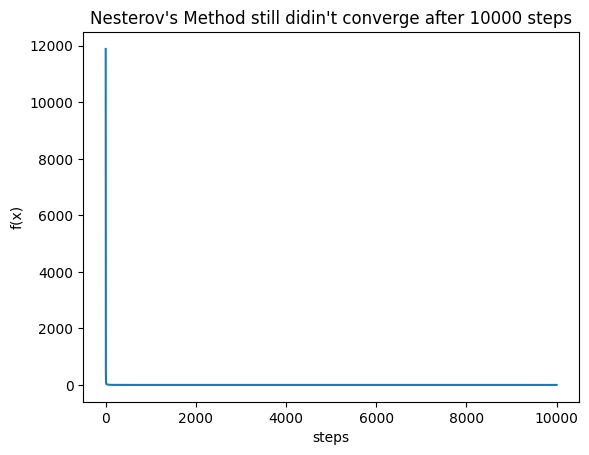

In [53]:
# Nesterov's Method
x0 = np.random.uniform(-4.5, 4.5, 2)

max_iter = 10000
xs, fs, step = nesterov(f, torch.tensor(x0), lr=1e-5, rho=0.7, tol=1e-8, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

This worked just about as well as Polyak's method.

The minimizer [ 0.36883462 -1.6374179 ] evaluates to 8.920902775071998


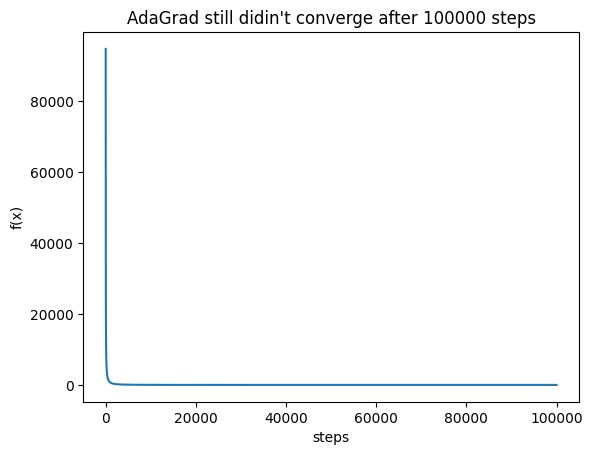

In [77]:
# AdaGrad
x0 = np.random.uniform(-4.5, 4.5, 2)

max_iter = 100000
xs, fs, step = adagrad(f, torch.tensor(x0), lr=1e-1, tol=1e-8, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

The convergence here was slower than the other methods. But, its convergence plot was much smoother, suggesting that it may generalize well.

The minimizer [2.99999847 0.49999962] evaluates to 3.7427535985908826e-13


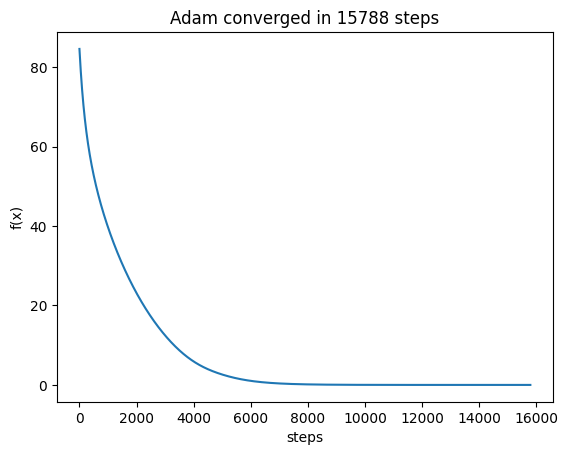

In [111]:
# Adam
x0 = np.random.uniform(-4.5, 4.5, 2)

max_iter = 100000
xs, fs, step = adam(f, torch.tensor(x0), lr=1e-3, tol=1e-8, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

This was the only method to actually find the minimizer!!!!! It really works.

**Equation 2**
\begin{align*}
    f(x_1, x_2) &= (x_1^2+x_2-11)^2+(x_1+x_2^2-7)^2 \\
    &-5\leq x_k\leq 5
\end{align*}
(The following four points at the minimizers $(-3.78,-3.29)$, $(-2.81, 3.10)$, $(3,2)$, and $(3.58, -1.82)$ which all make $f$ go to $0$.)

In [19]:
def f2(x):
  x1, x2 = x
  sum = (x1**2+x2-11)**2 + (x1+x2**2-7)**2
  return sum

The minimizer [-3.77171741 -3.2711809 ] evaluates to 0.007118888895859713


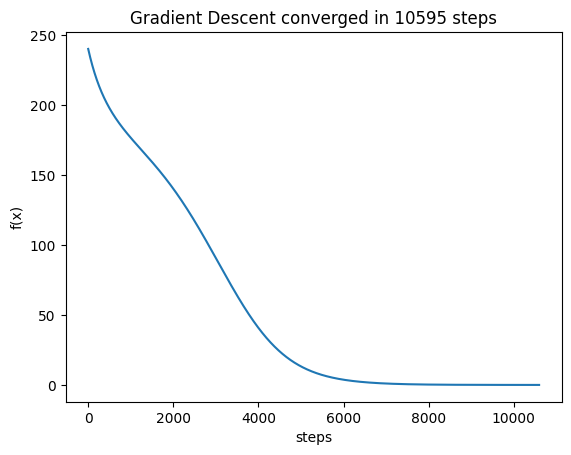

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-5., 5., 2)

max_iter = 40000
xs, fs, step = gradient_descent(f2, torch.tensor(x0), lr=1e-5, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

Gradient descent seemed to work a little better here (than the last equation). Though, the steps were also very slow in the end.

The minimizer [ 3.58747392 -1.88192979] evaluates to 0.016818562606334065


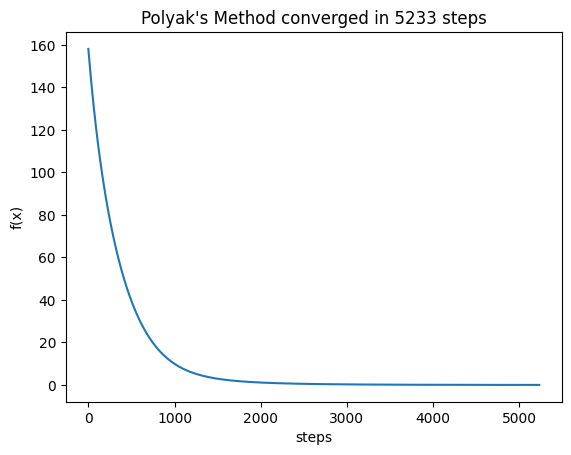

In [21]:
# Polyak's Method
x0 = np.random.uniform(-5., 5., 2)

max_iter = 40000
xs, fs, step = polyak(f2, torch.tensor(x0), lr=1e-5, tol=1e-5, rho=0.5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

This worked better than gradient descent. The converge was faster and smoother. Once again, this was when the value of momentum was large.

The minimizer [2.99248931 2.01767692] evaluates to 0.004780424216522538


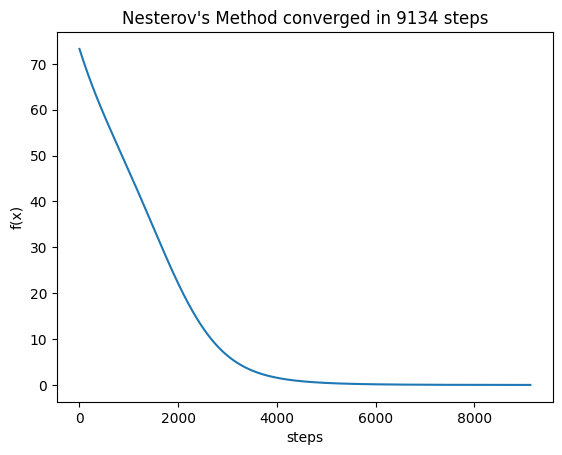

In [54]:
# Nesterov's Method
x0 = np.random.uniform(-5., 5., 2)

max_iter = 40000
xs, fs, step = nesterov(f2, torch.tensor(x0), lr=1e-5, tol=1e-5, rho=0.5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

The minimizer here was slightly better than the last method, though it took more iterations.

The minimizer [ 3.5844269  -1.84812572] evaluates to 1.0992374532988868e-10


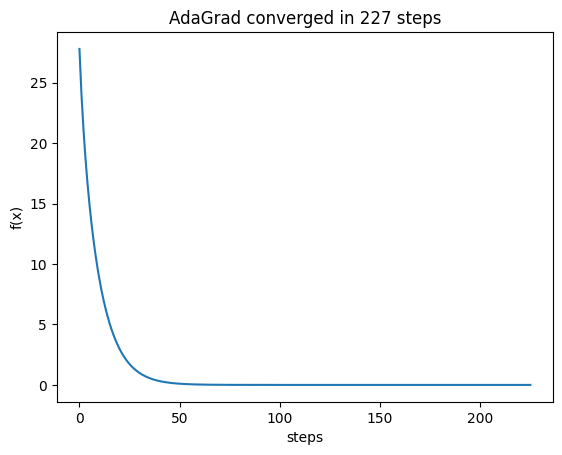

In [75]:
# AdaGrad
x0 = np.random.uniform(-5., 5., 2)

max_iter = 40000
xs, fs, step = adagrad(f2, torch.tensor(x0), lr=1e-1, tol=1e-7, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

This worked really well, but only when the learning rate was pretty large.

The minimizer [-3.77917721 -3.28298619] evaluates to 2.0390052823765334e-06


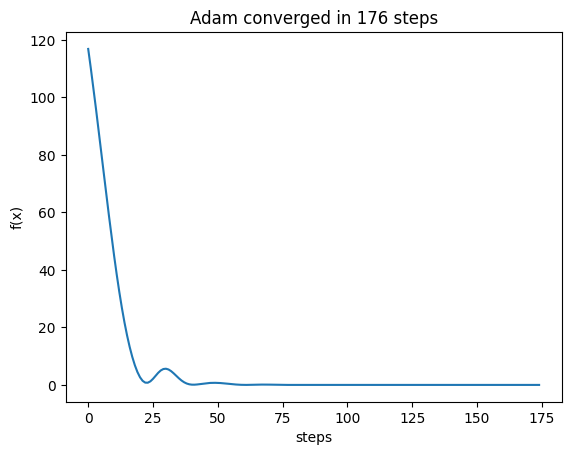

In [113]:
# Adam
x0 = np.random.uniform(-5., 5., 2)

max_iter = 40000
xs, fs, step = adam(f2, torch.tensor(x0), lr=1e-1, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

Adam also worked really well here.

**Equation 3**
\begin{align*}
    f(x_1, x_2) &= -(x_2+47)\sin(\sqrt{|\frac{x_1}{2}+x_2+47|})-x_1\sin(\sqrt{|x_1-(x_2+47)|}) \\
    &-512\leq x_k\leq 512
\end{align*}
(This one was too hard to find. Previous code says that the minimize is $(8.457,15.651)$ with the value $-66.84$ which may or may not be correct.)

In [23]:
def f3(x):
  x1, x2 = x
  sum = -(x2 + 47) * torch.sin(torch.sqrt(torch.abs((x1 / 2) + x2 + 47)))
  sum -= x1 * torch.sin(torch.sqrt(torch.abs(x1 - (x2 + 47))))
  return sum

The minimizer [  2.76282858 373.39011332] evaluates to -420.29202381691033


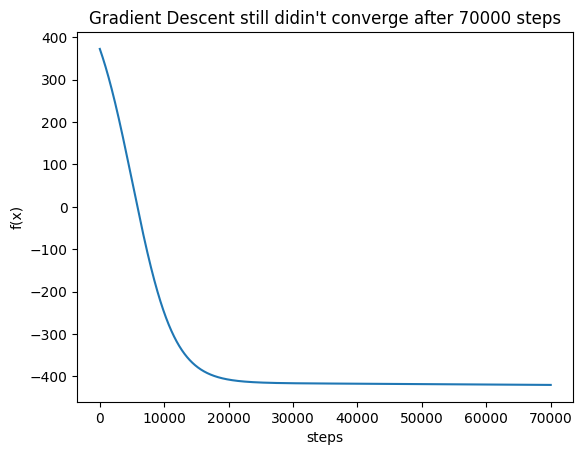

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-512., 512., 2)
max_iter = 70000
xs, fs, step = gradient_descent(f3, torch.tensor(x0), lr=5e-4, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

This one didn't work great either. To make it get any significant progess, I had to increase the number of steps. Also, I actually got a value less than what I found using scipy on the previous homework. But, it still did not converge. So, we cannot be sure if it is the correct result.

The minimizer [-176.6311015  -520.03807526] evaluates to -645.2761881254727


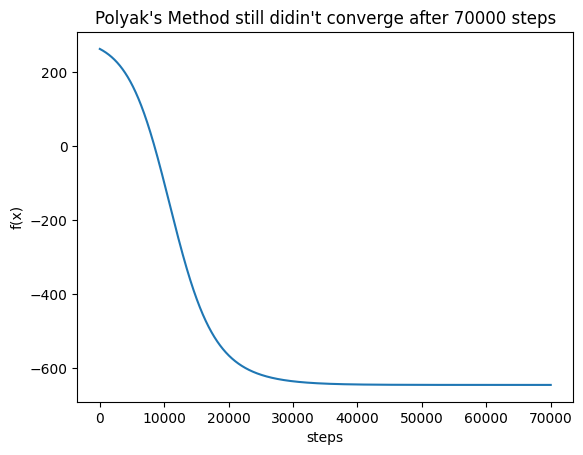

In [24]:
# Polyak's Method
x0 = np.random.uniform(-512., 512., 2)
max_iter = 70000
xs, fs, step = polyak(f3, torch.tensor(x0), lr=5e-4, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

Once again, this was better than gradient descent. However, we still failed to find the minimizer (though we did get closer)

The minimizer [-465.61725981  385.6924771 ] evaluates to -894.5781748913867


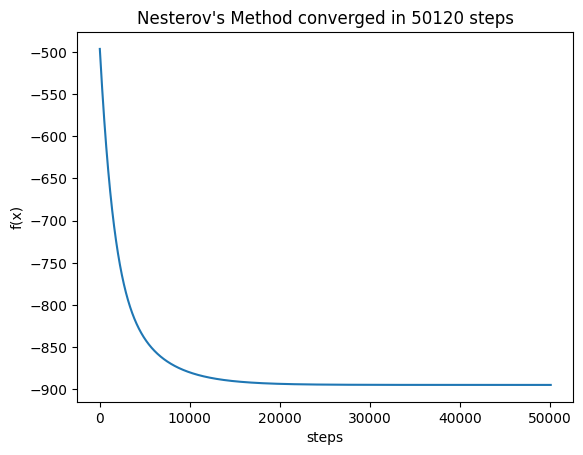

In [55]:
# Nesterov's Method
x0 = np.random.uniform(-512., 512., 2)
max_iter = 70000
xs, fs, step = nesterov(f3, torch.tensor(x0), lr=5e-4, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

This one is the best method so far. It even claimed to find the minimizer! Though, I can't be sure if it is the true answer.

The minimizer [182.75332242  73.39671571] evaluates to -292.7511847679675


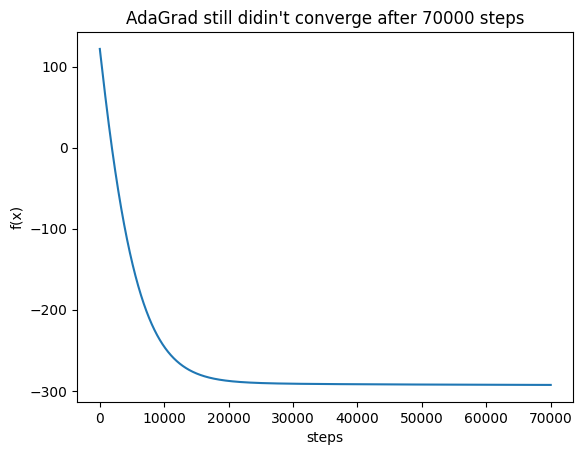

In [78]:
# AdaGrad
x0 = np.random.uniform(-512., 512., 2)
max_iter = 70000
xs, fs, step = adagrad(f3, torch.tensor(x0), lr=1e-1, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

This was slower again. But, the convergence was smooth. It probably will get the minimizer eventually.

The minimizer [-189.43287534 -258.48032212] evaluates to -395.8018245739536


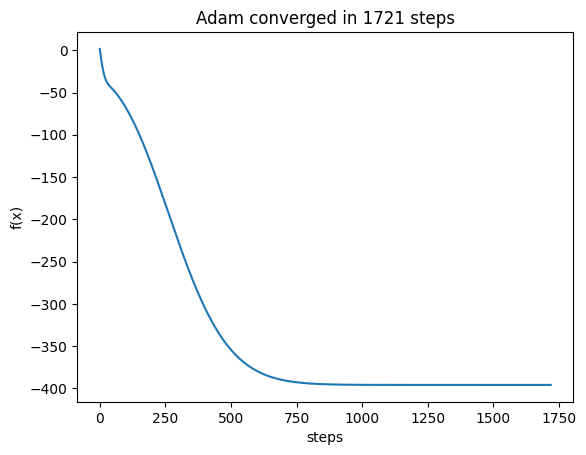

In [116]:
# Adam
x0 = np.random.uniform(-512., 512., 2)
max_iter = 70000
xs, fs, step = adam(f3, torch.tensor(x0), lr=1e-1, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

This found a local minimizer very quickly. Though, it still probably wasn't the global minimizer.

**Equation 4**
\begin{align*}
    f(x_1, x_2) &= -20e^{-0.2\sqrt{0.5(x_1^2+x_2^2)}}-e^{0.5(\cos(2\pi x_1)+\cos(2\pi x_2))}+e+20 \\
    &-5\leq x_k\leq 5
\end{align*}
($(0,0)$ is the minimizer (which evaluates to $e-1$))

In [25]:
def f4(x):
  x1, x2 = x
  sum = -20 * torch.exp(-0.2 * torch.sqrt(0.5 * (x1**2 + x2**2)))
  sum -= torch.exp(0.5 * (torch.cos(2 * torch.pi * x1) + torch.cos(2 * torch.pi * x2)))
  sum += torch.exp(torch.tensor(1.)) + 20
  return sum

The minimizer [-2.96448168e+00  3.47820131e-04] evaluates to 6.882585329934901


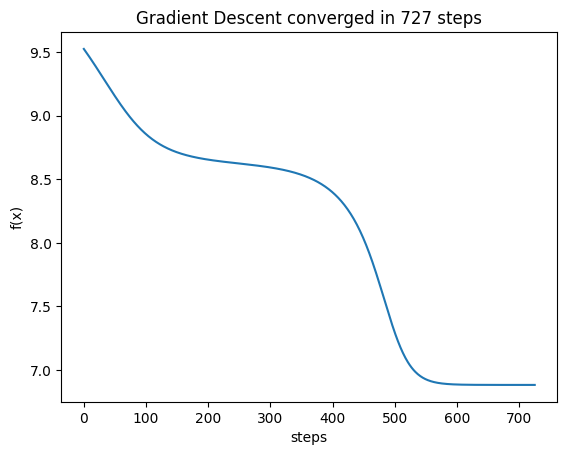

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-5., 5., 2)
max_iter = 30000
xs, fs, step = gradient_descent(f4, torch.tensor(x0), lr=5e-4, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

This one claimed to have converged. But, it must have only found a local minimum. Our calculation from the homework gave a better answer.

The minimizer [-1.98731243  3.97415889] evaluates to 9.353041965558596


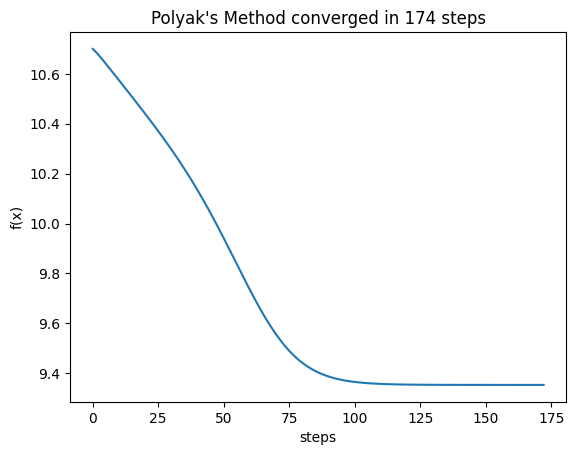

In [27]:
# Polyak's Method
x0 = np.random.uniform(-5., 5., 2)
max_iter = 30000
xs, fs, step = polyak(f4, torch.tensor(x0), lr=5e-4, tol=1e-5, rho=0.5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

The results here were similar to gradient descent. Although it converged to a local min faster, it did not find the global minimizer.

The minimizer [-0.98239524  1.96442905] evaluates to 5.381864041671118


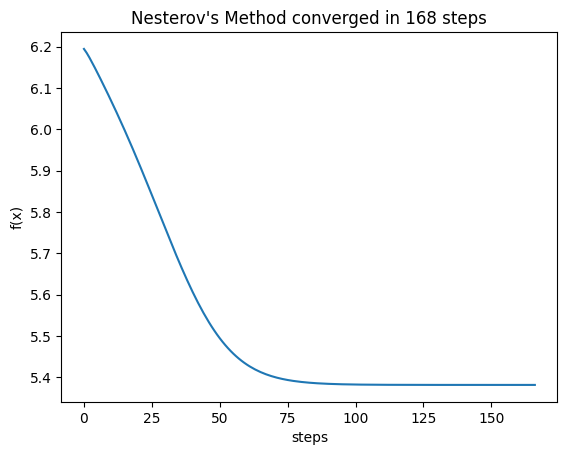

In [56]:
# Nesterov's Method
x0 = np.random.uniform(-5., 5., 2)
max_iter = 30000
xs, fs, step = nesterov(f4, torch.tensor(x0), lr=5e-4, tol=1e-5, rho=0.5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

Once again, it claimed to converge but didn't. However, this method found the lowest value for the loss.

The minimizer [-0.96847734  0.96848314] evaluates to 3.5744508418123857


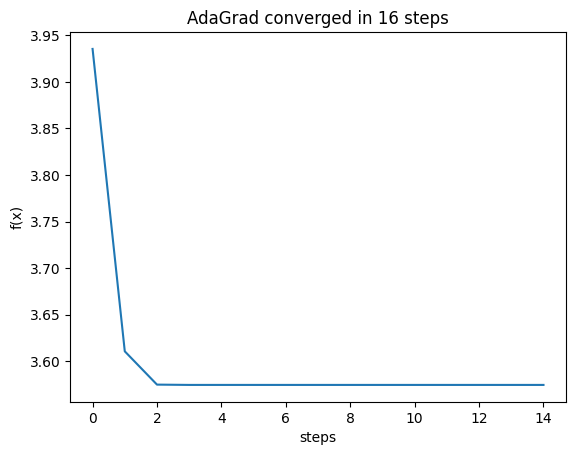

In [81]:
# AdaGrad
x0 = np.random.uniform(-5., 5., 2)
max_iter = 30000
xs, fs, step = adagrad(f4, torch.tensor(x0), lr=1e-1, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

This one worked incredibly cook and found a goot local min. But, it still wasn't the global minimizer.

The minimizer [-0.9684918  -0.96849929] evaluates to 3.57445085753168


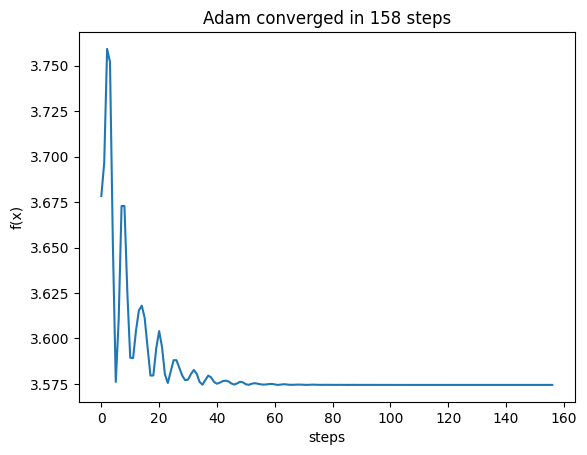

In [118]:
# Adam
x0 = np.random.uniform(-5., 5., 2)
max_iter = 30000
xs, fs, step = adam(f4, torch.tensor(x0), lr=1e-1, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

The results here were similar to that of AdaGrad

**Equation 5**
\begin{align*}
    f(x_1, x_2) &= \sin^2(3\pi x_1) + (x_1-1)^2(1+\sin^2(3\pi x_2)) + (x_2-1)^2(1+\sin^2(2\pi x_2)) \\
    &-10\leq x_k\leq 10
\end{align*}
(The only minimizer is $(x_1,x_2)=(1,1)$, which makes $f$ equal to $0$.)

In [28]:
def f5(x):
  x1, x2 = x
  sum = torch.sin(3 * torch.pi * x1) ** 2
  sum += (x1 - 1) ** 2 * (1 + torch.sin(3 * torch.pi * x2) ** 2)
  sum += (x2 - 1) ** 2 * (1 + torch.sin(2 * torch.pi * x2) ** 2)
  return sum

The minimizer [ 4.92989487 -3.37732594] evaluates to 46.788475952194176


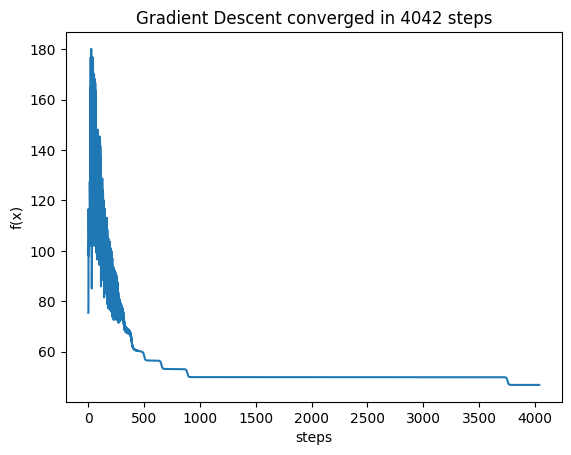

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-19., 10., 2)
max_iter = 30000
xs, fs, step = gradient_descent(f5, torch.tensor(x0), lr=5e-4, tol=1e-6, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

This was similar to the last problem. It converged to a local min, not the global min.

The minimizer [-3.59520087 -0.33470285] evaluates to 24.612635157628855


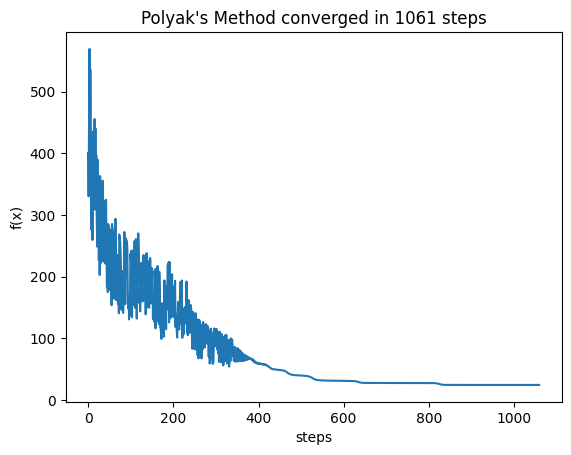

In [32]:
# Polyak's Method
x0 = np.random.uniform(-19., 10., 2)
max_iter = 30000
xs, fs, step = polyak(f5, torch.tensor(x0), lr=5e-4, tol=1e-6, rho=0.2, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

This was marginally better than gradient descent. It was faster and happened to find a better local min. But, it didn't find the global min.

The minimizer [-3.27308447 -0.33492356] evaluates to 21.655615773141776


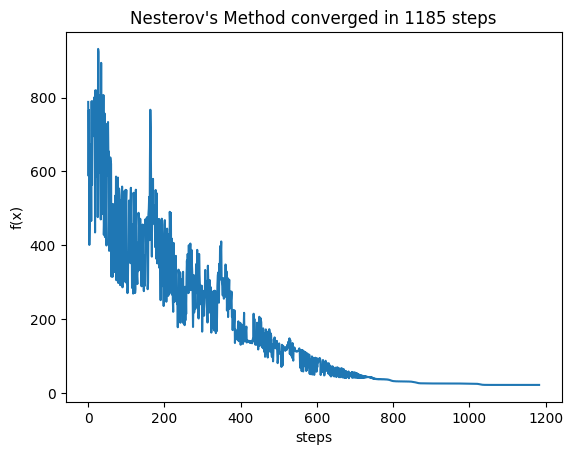

In [58]:
# Nesterov's Method
x0 = np.random.uniform(-19., 10., 2)
max_iter = 30000
xs, fs, step = nesterov(f5, torch.tensor(x0), lr=5e-4, tol=1e-6, rho=0.2, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

This was similar to Polyak's method.

The minimizer [-3.59442266 -1.33947791] evaluates to 30.966812012749013


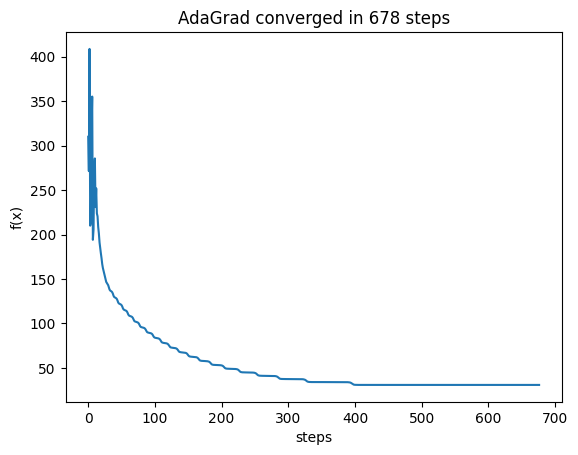

In [88]:
# AdaGrad
x0 = np.random.uniform(-19., 10., 2)
max_iter = 30000
xs, fs, step = adagrad(f5, torch.tensor(x0), lr=5e-1, tol=1e-11, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

This one claimed to converge well and was much quicker and smoother than the last. But, it didn't actually find the minimizer.

The minimizer [-0.64770448 -7.99738101] evaluates to 83.72296811897787


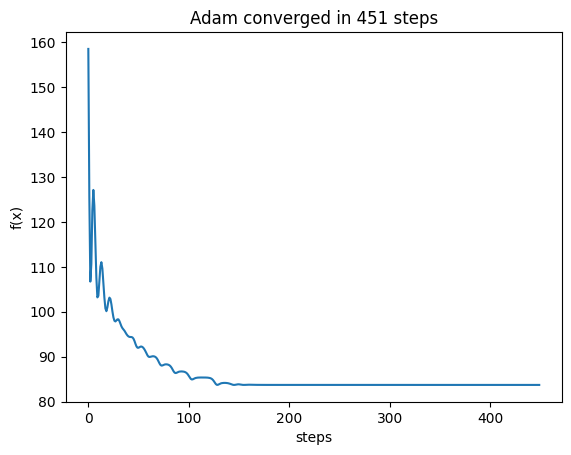

In [122]:
# Adam
x0 = np.random.uniform(-19., 10., 2)
max_iter = 30000
xs, fs, step = adam(f5, torch.tensor(x0), lr=5e-2, tol=1e-11, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

This actually wasn't as good as the last one. At least, the local min that it found was a bit worse.

**Equation 6**
\begin{align*}
    f(x) &= \frac{1}{2}\sum_{k=1}^4[x_k^4-16x_k^2+5x_k] \\
    &-5\leq x_k\leq 5
\end{align*}
(The minimizers are $(-2.904,-2.904,-2.904,-2.904)$, $(0.157,0.157,0.157,0.157)$, and $(2.747,2.747,2.747,2.747)$. Here, the function evaluates to $-156.66$, $0.782$, and $-100.12$. The global minimizer is just $(-2.904,-2.904,-2.904,-2.904)$.)

In [33]:
def f6(x):
  x1, x2, x3, x4 = x
  sum = (x1**4 - 16 * x1**2 + 5 * x1)
  sum += (x2**4 - 16 * x2**2 + 5 * x2)
  sum += (x3**4 - 16 * x3**2 + 5 * x3)
  sum += (x4**4 - 16 * x4**2 + 5 * x4)
  return sum / 2

The minimizer [-2.90353399  2.74338021  2.74680277  2.74680268] evaluates to -114.25433445866474


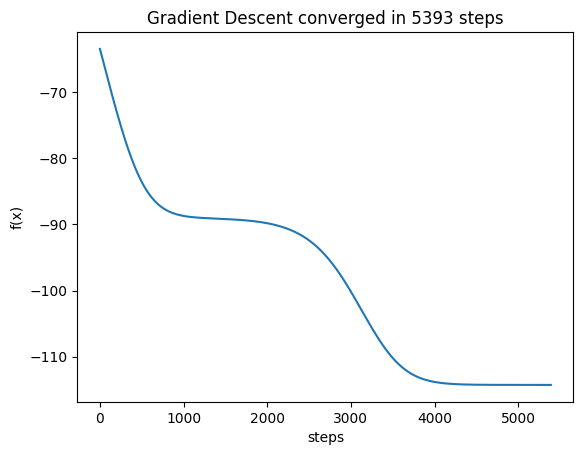

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-5., 5., 4)
max_iter = 30000
xs, fs, step = gradient_descent(f6, torch.tensor(x0), lr=1e-4, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

This worked okay. It got close to the global min. But, it was a little off. Some of the values should have been negative when they were calculated to be positive.

The minimizer [-2.90356364 -2.90368214 -2.90065642 -2.90369072] evaluates to -156.66451894970083


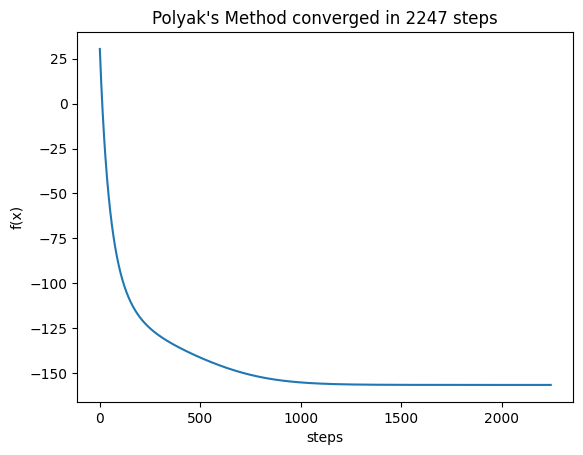

In [34]:
# Polyak's Method
x0 = np.random.uniform(-5., 5., 4)
max_iter = 30000
xs, fs, step = polyak(f6, torch.tensor(x0), lr=1e-4, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

Unlike gradient descent, this method worked! It found the minimizer and converged faster.

The minimizer [ 2.74714945 -2.90098661  2.74720586  2.74710697] evaluates to -114.25438806317632


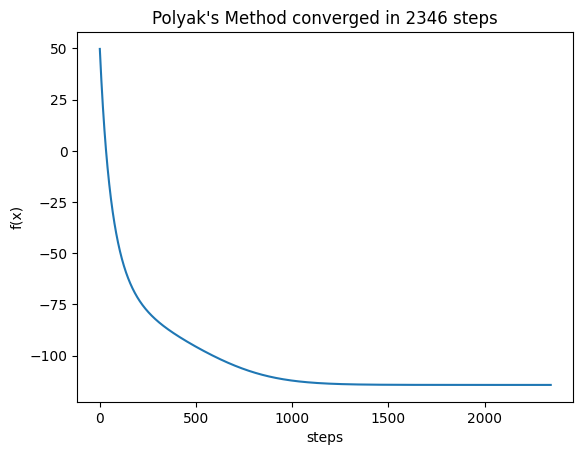

In [60]:
# Nesterov's Method
x0 = np.random.uniform(-5., 5., 4)
max_iter = 30000
xs, fs, step = nesterov(f6, torch.tensor(x0), lr=1e-4, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

This one had the same output as gradient descent (though it was more smooth). This makes me think that the last method got lucky. But, I can't be sure.

The minimizer [-2.90353403 -2.9034926  -2.90353358 -2.90300221] evaluates to -156.66465789563247


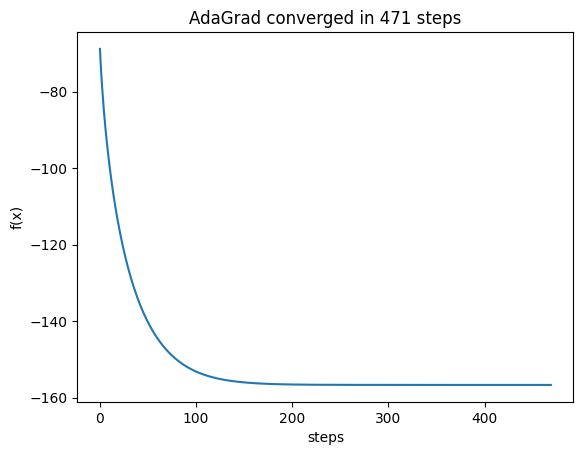

In [90]:
# AdaGrad
x0 = np.random.uniform(-5., 5., 4)
max_iter = 30000
xs, fs, step = adagrad(f6, torch.tensor(x0), lr=1e-1, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

This method worked the best of all of them, so far.

The minimizer [-2.90353726 -2.90355356 -2.90356281 -2.90358123] evaluates to -156.6646627554582


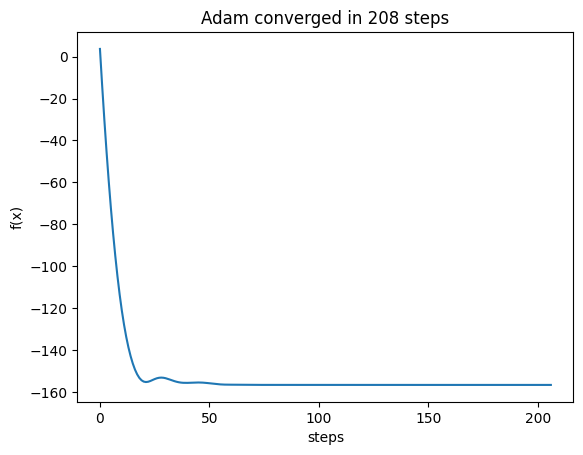

In [129]:
# Adam
x0 = np.random.uniform(-5., 5., 4)
max_iter = 30000
xs, fs, step = adam(f6, torch.tensor(x0), lr=1e-1, tol=1e-5, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

This one was similar to AdaGrad, but it bit faster. So, it was great for this function.

**Equation 7**
\begin{align*}
    f(x) &= 10,000+\sum_{k=1}^{1,000}[x_k^2-10\cos(2\pi x_k)] \\
    &-5.12\leq x_k\leq 5.12
\end{align*}
(The minimizer is a 1,000 dimensional vector where each term is $1$. This evaluates to $1,000$ )

In [35]:
def f7(x):
  sum = 10000
  for xi in x:
    sum += xi**2 - 10 * torch.cos(2 * torch.pi * xi)
  return sum

The minimizer [-9.94958637e-01  9.94958637e-01 -2.98485570e+00 -2.47995211e-10
 -2.98485570e+00 -2.98485571e+00  3.97978386e+00  1.77814975e-08
  2.98485570e+00  4.97469139e+00  1.98991223e+00  9.94958639e-01
  2.98485570e+00  2.98485570e+00  4.97469139e+00  1.98991223e+00
  3.97978386e+00 -1.98991223e+00 -1.98991227e+00  3.97978386e+00
 -4.97469139e+00 -2.98485570e+00 -9.94958626e-01 -4.97469138e+00
 -3.97978386e+00  9.94958638e-01  2.98485570e+00  5.64634828e-10
 -1.98991223e+00 -1.09283745e-09  1.98991224e+00  1.98991223e+00
  9.94958638e-01  9.94958637e-01 -4.97469139e+00  4.97469138e+00
  3.97978386e+00 -3.97978386e+00  9.94958635e-01 -2.98485570e+00
 -9.94958636e-01  3.97978387e+00 -9.94958637e-01 -2.98485570e+00
  2.98485571e+00 -1.98991223e+00 -1.98991224e+00  3.97978386e+00
  4.97469138e+00 -2.98485570e+00 -2.98485568e+00 -8.55750090e-10
 -4.97469139e+00 -1.98991223e+00 -4.04353087e-10 -3.97978386e+00
  2.98485570e+00 -9.94958641e-01  9.94958638e-01  3.97978385e+00
  1.9899122

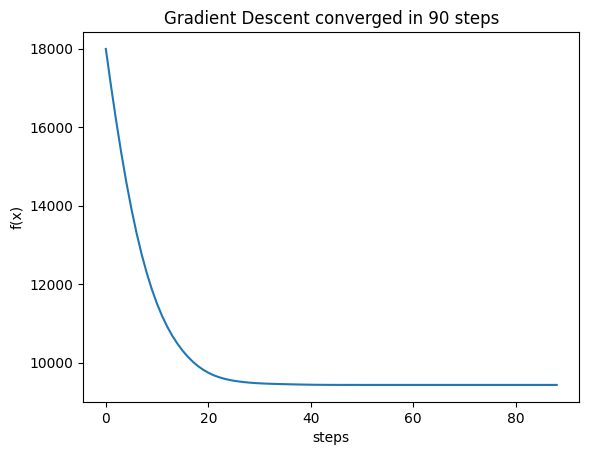

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-5.12, 5.12, 1000)
max_iter = 1000
xs, fs, step = gradient_descent(f7, torch.tensor(x0), lr=5e-4, tol=1e-6, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

This one claimed to converge. But, it didn't get anywhere near close to it. The loss was about 8,000 more than it should be. And, the minimizer seemed random.

The minimizer [ 9.94958641e-01  3.97978386e+00 -2.98485570e+00  9.94958637e-01
 -9.94958631e-01 -1.98991223e+00  9.94958611e-01  9.94958638e-01
 -1.98991292e+00  1.98991223e+00 -4.97469139e+00 -9.94958642e-01
  3.97978386e+00  2.98485570e+00 -3.66646710e-10  1.98991223e+00
  9.94958640e-01  1.98991221e+00 -4.97469139e+00 -3.97978386e+00
 -9.94958638e-01  9.94958638e-01 -3.97978386e+00  2.85694238e-10
 -4.97469139e+00  3.97978386e+00 -1.31440053e-09  2.98485570e+00
 -2.98485570e+00  1.98991224e+00 -9.94958639e-01 -1.16868008e-09
  1.70542787e-09  3.97978386e+00  3.97978387e+00 -2.98485571e+00
  2.98485569e+00  1.98991223e+00 -1.98991224e+00  4.97469139e+00
 -1.98991223e+00 -8.04629923e-10 -1.98991224e+00 -9.94958637e-01
  2.98485570e+00  9.94958637e-01  9.94958638e-01  1.98991223e+00
 -2.98485566e+00  1.98991220e+00 -2.83943714e-11  3.97978386e+00
 -1.98991223e+00  9.94958639e-01 -2.98485570e+00 -1.98991224e+00
  4.97469139e+00 -2.98485570e+00  3.97978386e+00 -3.97978386e+00
 -2.9848557

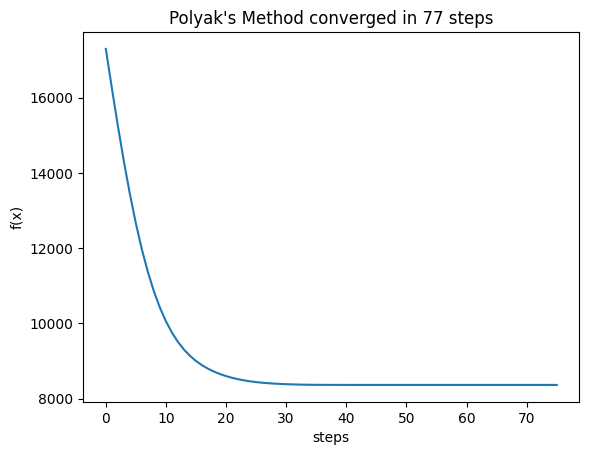

In [36]:
# Polyak's Method
x0 = np.random.uniform(-5.12, 5.12, 1000)
max_iter = 1000
xs, fs, step = polyak(f7, torch.tensor(x0), lr=5e-4, tol=1e-6, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

This only marginally improved the results from gradient descent. It was a bit quicker and found a slightly better value for the loss.

The minimizer [-3.97978386e+00  2.98485575e+00  2.98485570e+00 -1.98991223e+00
  2.98485571e+00  2.98485563e+00  4.97469139e+00 -4.97469139e+00
  2.98485571e+00 -8.52201193e-10 -9.94958638e-01  1.98991223e+00
  3.97978386e+00 -9.94958638e-01 -2.98485570e+00 -9.94958638e-01
  2.98485570e+00 -3.97978386e+00  1.25916771e-09 -1.98991223e+00
 -4.05444058e-09  2.98485570e+00 -1.98991223e+00  2.98485570e+00
 -1.61770575e-08 -3.97978386e+00 -9.94958638e-01  2.98485584e+00
 -2.98485570e+00 -3.97978385e+00  2.98485570e+00  4.97469139e+00
 -9.94958638e-01  3.97978386e+00 -1.98991223e+00 -3.97978386e+00
  3.97978386e+00 -2.45147853e-10 -2.98485570e+00  8.45086797e-11
  4.97469139e+00  1.98991223e+00  2.98485570e+00  1.98991223e+00
 -3.97978386e+00 -3.97978386e+00 -1.98991224e+00 -2.98485570e+00
  7.51967825e-10 -1.98991223e+00 -2.98485570e+00  1.98991223e+00
 -1.98991223e+00 -1.98991223e+00  3.97978386e+00  2.98485570e+00
 -1.98991223e+00  1.98991223e+00  3.97978387e+00  1.98991223e+00
 -3.9797838

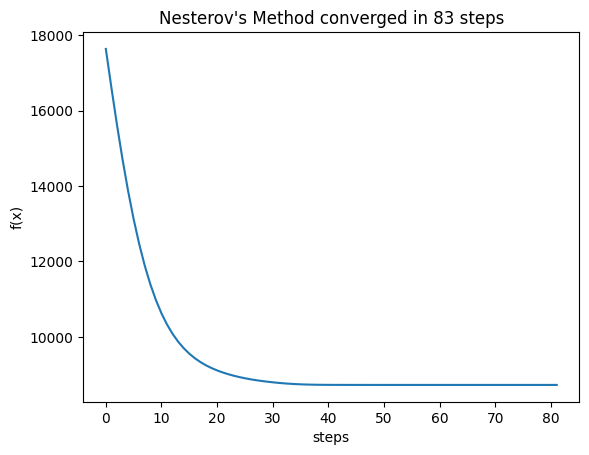

In [61]:
# Nesterov's Method
x0 = np.random.uniform(-5.12, 5.12, 1000)
max_iter = 1000
xs, fs, step = nesterov(f7, torch.tensor(x0), lr=5e-4, tol=1e-6, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

The results here were similar to the last two methods.

The minimizer [-8.60697510e-010 -4.97469139e+000 -1.98991223e+000 -2.98485570e+000
 -1.98991223e+000  2.98485570e+000  2.20254451e-191 -1.98991223e+000
  3.97978386e+000  9.94958638e-001  9.94958638e-001 -3.97978386e+000
  4.97469139e+000 -1.98991223e+000 -1.94575356e-010 -2.98485570e+000
 -2.75652715e-011  4.97469139e+000  3.97978386e+000 -3.97978386e+000
 -2.98485570e+000  1.98991223e+000 -3.97978386e+000 -4.44426677e-123
  3.97978386e+000  9.94958640e-001 -9.94958638e-001 -9.94958638e-001
 -9.94958637e-001 -1.98991223e+000 -8.64595053e-010  4.97469139e+000
  9.94958638e-001  9.94958638e-001  3.97978386e+000 -8.66230695e-228
 -2.98485571e+000  3.97978386e+000 -2.98485570e+000 -1.98991223e+000
  9.94958638e-001  2.98485570e+000 -2.98485570e+000 -1.98991223e+000
 -1.98991224e+000  2.98485570e+000 -2.98485570e+000  1.98991224e+000
  1.98991224e+000  4.97469139e+000 -3.97978386e+000  1.98991223e+000
  1.98991223e+000  4.97469139e+000 -8.64858236e-010 -2.98485570e+000
 -9.94958637e-001  2

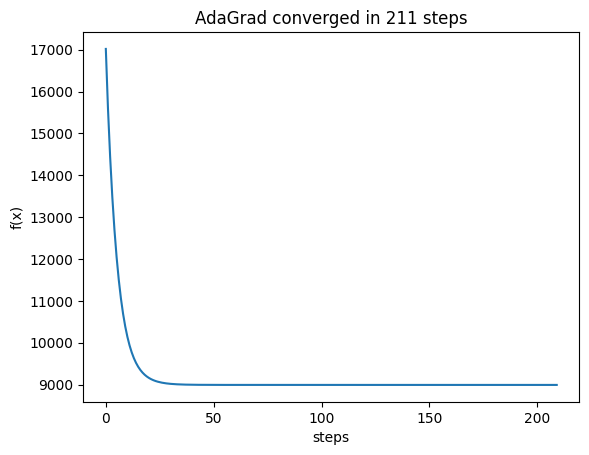

In [95]:
# AdaGrad
x0 = np.random.uniform(-5.12, 5.12, 1000)
max_iter = 500
xs, fs, step = adagrad(f7, torch.tensor(x0), lr=5e-2, tol=1e-8, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

This performed similarly to other methods.

The minimizer [ 3.97978386e+00  2.98485570e+00 -1.98991223e+00  2.98485570e+00
  3.97978386e+00 -1.98991223e+00 -2.98485570e+00  1.98991223e+00
 -1.98991223e+00  4.97469139e+00  2.98485570e+00 -2.98485570e+00
  9.94958637e-01  2.98485570e+00  3.97978386e+00 -1.98991223e+00
 -9.94958638e-01 -3.97978386e+00  1.98991223e+00 -3.97978386e+00
 -1.98991223e+00  3.97978386e+00  1.98991223e+00 -4.97469139e+00
  1.98991223e+00  9.94958637e-01 -3.97978386e+00  1.98991223e+00
  2.28777244e-10 -1.98991223e+00 -3.97978386e+00 -3.97978386e+00
  2.98485570e+00 -2.98485570e+00  1.98991223e+00 -2.98485570e+00
  3.97978386e+00  3.97978386e+00 -1.98991223e+00  1.98991223e+00
  1.18023179e-09 -1.98991223e+00  9.94958638e-01 -9.94958637e-01
 -2.98485570e+00  2.98485570e+00  3.97978386e+00  1.98991223e+00
  3.97978386e+00  2.98485570e+00  2.98485570e+00  1.98991223e+00
  1.98991223e+00 -7.35947301e-10 -1.98991223e+00 -9.94958638e-01
 -1.98991223e+00 -4.86968912e-11 -4.21970381e-10 -9.94958637e-01
  9.9495863

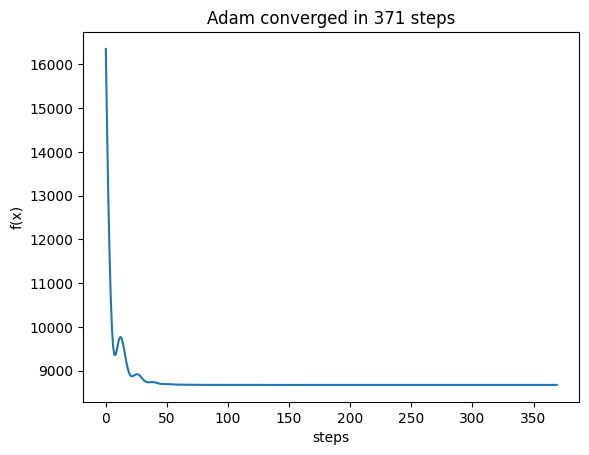

In [130]:
# Adam
x0 = np.random.uniform(-5.12, 5.12, 1000)
max_iter = 500
xs, fs, step = adam(f7, torch.tensor(x0), lr=5e-2, tol=1e-8, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

The results of this one were similar to the other algorithms.

**Equation 8**
\begin{align*}
    f(x) &= \sum_{k=1}^{1,000}[100(x_{k+1}-x_k^2)^2+(1-x_k)^2]
\end{align*}
(The minimizer is the 1,000 dimensional vector of $1$s, which evaluates to $0$ in the end.)

In [37]:
def f8(x):
  sum = 0
  for i in range(len(x) - 1):
    sum += 100 * (x[i + 1] - x[i]**2)**2 + (1 - x[i])**2
  return sum

The minimizer [ 0.23487109 -0.89668706  1.09191904 ...  1.07043725  1.49916672
  2.3900248 ] evaluates to 16177.358482776674


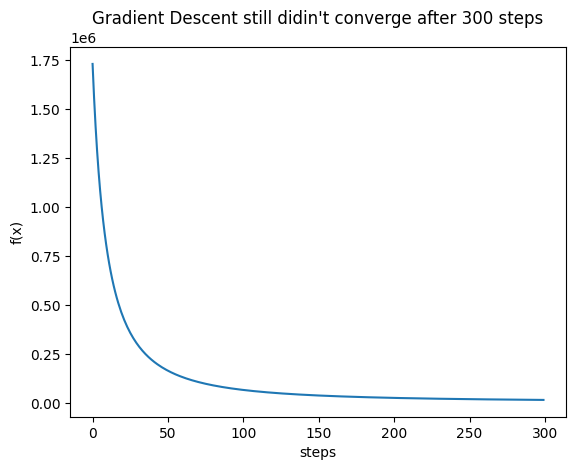

In [ ]:
# Gradient Descent
x0 = np.random.uniform(-3., 3., 1001)
max_iter = 300
xs, fs, step = gradient_descent(f8, torch.tensor(x0), lr=1e-5, tol=1e-6, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Gradient Descent", step, max_iter=max_iter)

This one took pretty long at each step (which makes sense because the tensor had 1,001 elements). So, I only let it run for 300 steps. Also, since we were given no range of the starting point, is let each element be between -3 and 3.

Because of the temporal complexity, it didn't converge to the desired level. But, the loss function did seem to be approaching a somewhat small value. However, due to the size of the array, the loss was still much different than the global min we calculated before (which was 0).

The minimizer [ 0.71354443  0.32336025 -0.4042588  ...  0.97110647  1.28233139
  1.79605023] evaluates to 11878.96122844374


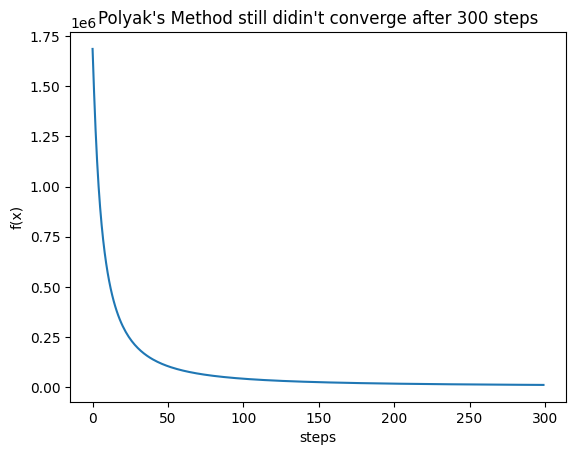

In [39]:
# Polyak's Method
x0 = np.random.uniform(-3., 3., 1001)
max_iter = 300
xs, fs, step = polyak(f8, torch.tensor(x0), lr=1e-5, tol=1e-6, rho=0.3, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Polyak's Method", step, max_iter=max_iter)

This was a bit better than gradient descent. It got a better result. But it still took quite a long time, forcing me to stop before convergence (at just 300 epochs).

The minimizer [ 0.73551872  0.40690904 -0.16235776 ...  0.07231916 -1.00076243
  1.41211719] evaluates to 11226.606215556974


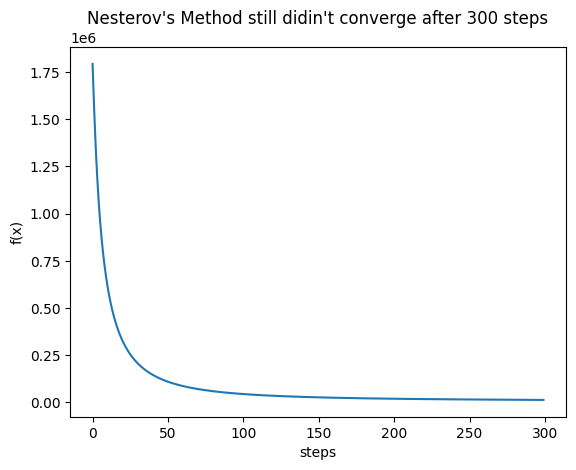

In [62]:
# Nesterov's Method
x0 = np.random.uniform(-3., 3., 1001)
max_iter = 300
xs, fs, step = nesterov(f8, torch.tensor(x0), lr=1e-5, tol=1e-6, rho=0.3, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Nesterov's Method", step, max_iter=max_iter)

The results here were similar to the last method

The minimizer [-1.22066102  0.5827429  -0.50169453 ...  0.11569953 -0.6645698
 -0.41435926] evaluates to 38015.99046504163


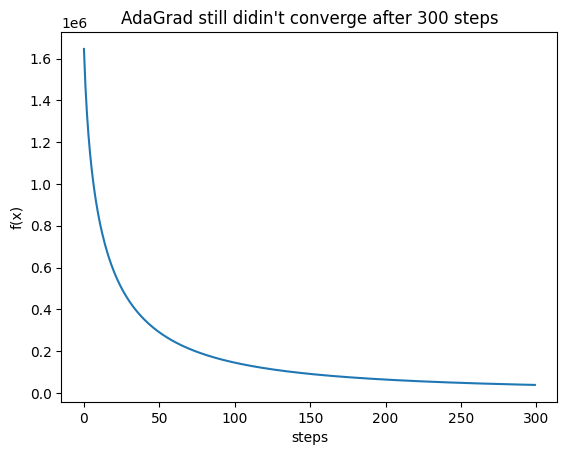

In [96]:
# AdaGrad
x0 = np.random.uniform(-3., 3., 1001)
max_iter = 300
xs, fs, step = adagrad(f8, torch.tensor(x0), lr=1e-1, tol=1e-6, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "AdaGrad", step, max_iter=max_iter)

This was also similar to the last few methods (though a bit slower, meaning that its final value for the function was larger)

The minimizer [-5.04114445e-01  2.66753172e-01  8.02206941e-02 ...  1.00627407e-02
  9.57170214e-03  8.84779734e-05] evaluates to 1851.5425234337229


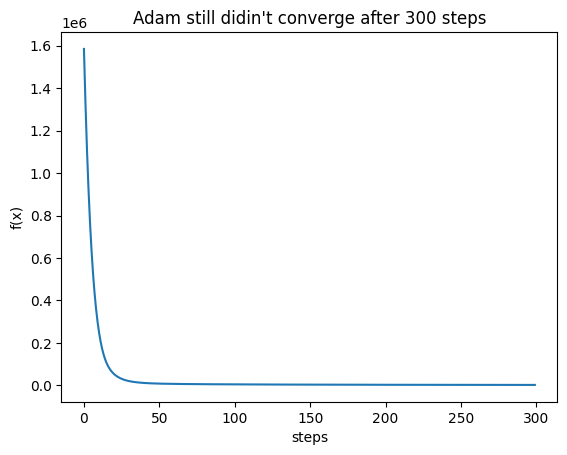

In [131]:
# Adam
x0 = np.random.uniform(-3., 3., 1001)
max_iter = 300
xs, fs, step = adam(f8, torch.tensor(x0), lr=1e-1, tol=1e-6, max_iter=max_iter)
print(f"The minimizer {xs[-1]} evaluates to {fs[-1]}")
plot_error(fs, "Adam", step, max_iter=max_iter)

This method worked better than all the rest, getting much closer to the minimizer. But, it still was 1851 away. So, this is definitely not a good function to optimize.